# Rag From Scratch: Indexing

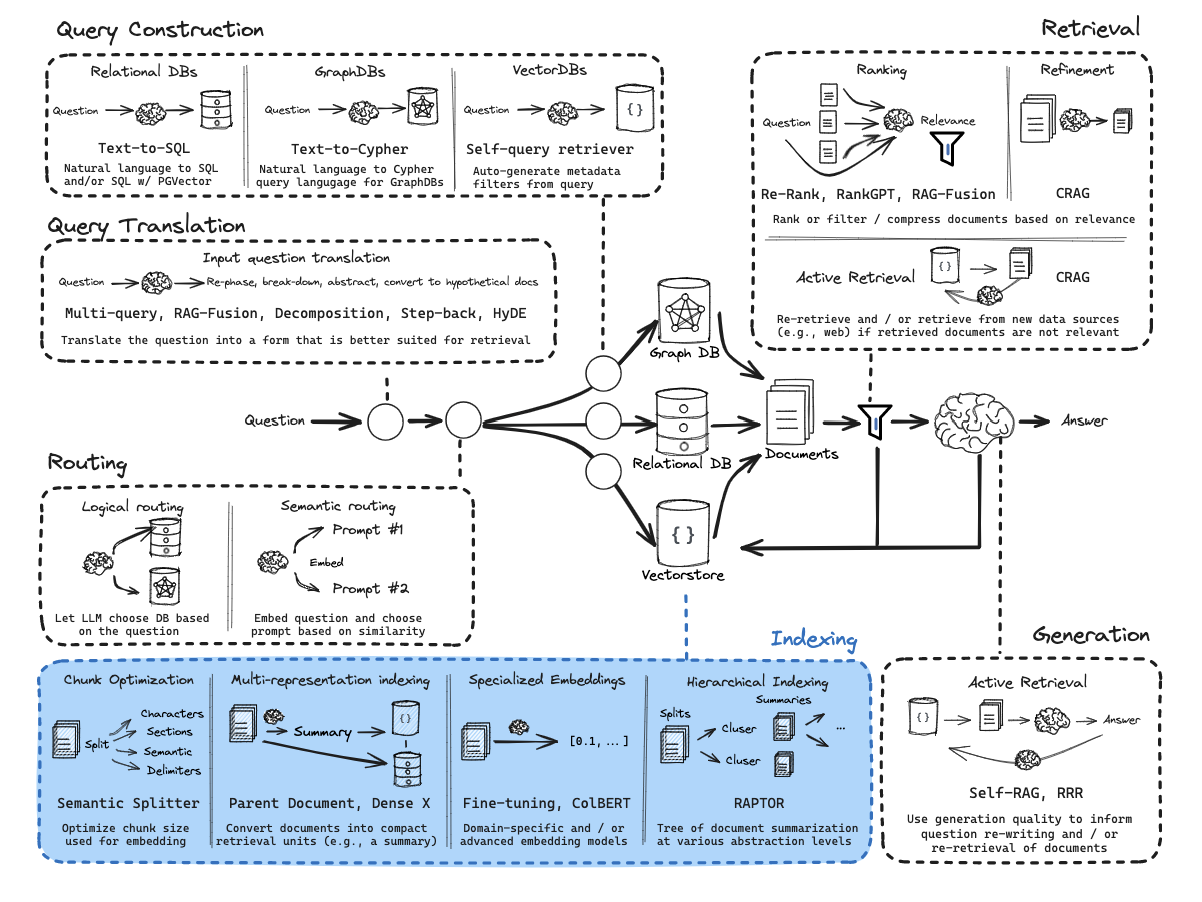

**Preface: Chunking**
We don't explicitly cover document chunking / splitting.

For an excellent review of document chunking, see this video from Greg Kamradt:

https://www.youtube.com/watch?v=8OJC21T2SL4

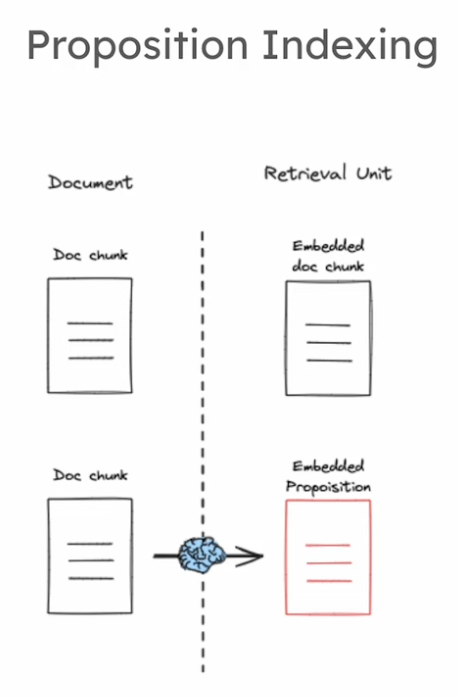

https://python.langchain.com/docs/how_to/multi_vector/

##  Multi-representation Indexing

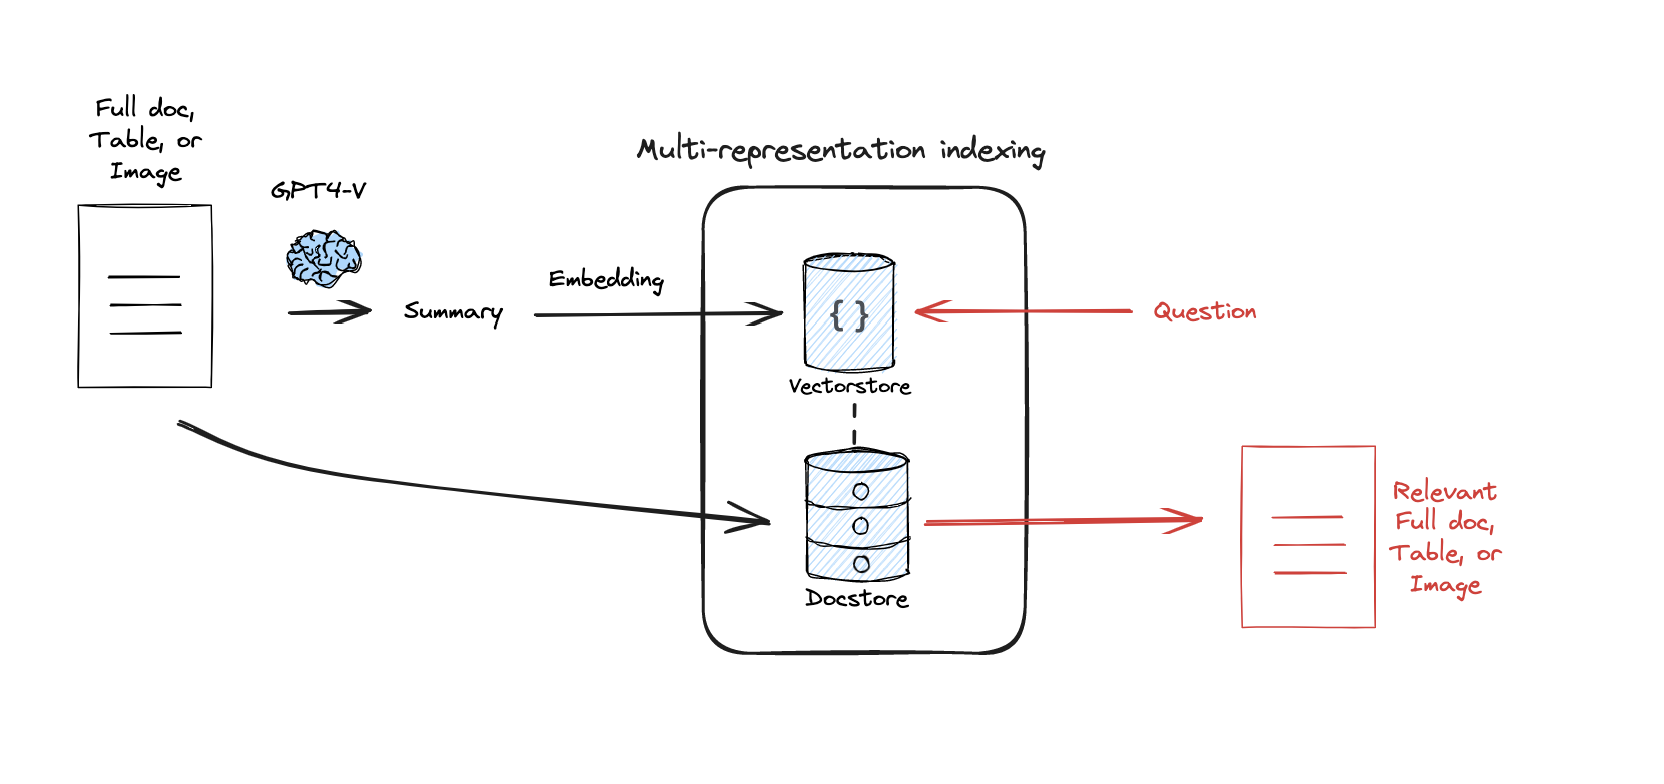

Docs:

- https://blog.langchain.dev/semi-structured-multi-modal-rag/

- https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector
- Related idea is the [parent document retriever](https://python.langchain.com/docs/how_to/parent_document_retriever/).

Paper:

- https://arxiv.org/abs/2312.06648

In [1]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

loader = WebBaseLoader("https://lilianweng.github.io/posts/2024-02-05-human-data-quality/")
docs.extend(loader.load())

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
import uuid

from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
# from langchain_openai import ChatOpenAI
from gen_ai_hub.proxy.langchain.init_models import init_embedding_model, init_llm
llm = init_llm(model_name="gpt-4o",max_retries=0)

chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | llm
    | StrOutputParser()
)

summaries = chain.batch(docs, {"max_concurrency": 5})

In [3]:
from langchain.storage import InMemoryByteStore
from langchain_community.vectorstores import Chroma
from langchain.retrievers.multi_vector import MultiVectorRetriever

embeddings = init_embedding_model(model_name="text-embedding-ada-002")
# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="summaries",
                     embedding_function=embeddings)

# The storage layer for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"

# The retriever
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)
doc_ids = [str(uuid.uuid4()) for _ in docs]

# Docs linked to summaries
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(summaries)
]

# Add
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))

/var/folders/56/hr4t2kyn4zd1r_vn51tycxyh0000gn/T/ipykernel_49684/2401856416.py:7: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name="summaries",


In [4]:
query = "Memory in agents"
sub_docs = vectorstore.similarity_search(query,k=1)
sub_docs[0]

Document(metadata={'doc_id': '48711e10-02eb-4816-9f5d-cac999f1dc8a'}, page_content='The document "LLM Powered Autonomous Agents" by Lilian Weng, published on June 23, 2023, explores the concept of building autonomous agents using large language models (LLMs) as the core controller. The article is divided into several sections, including an overview of agent systems, planning, memory, tool use, case studies, and challenges.\n\n**Agent System Overview:**\nLLMs serve as the brain of autonomous agents, complemented by components for planning, memory, and tool use.\n\n**Planning:**\n- **Task Decomposition:** Techniques like Chain of Thought (CoT) and Tree of Thoughts (ToT) help break down complex tasks into manageable steps.\n- **Self-Reflection:** Methods like ReAct, Reflexion, Chain of Hindsight (CoH), and Algorithm Distillation (AD) enable agents to learn from past actions and improve iteratively.\n\n**Memory:**\n- **Types of Memory:** Sensory, short-term, and long-term memory are mapped

In [5]:
retrieved_docs = retriever.get_relevant_documents(query,n_results=1)
retrieved_docs[0].page_content[0:500]

/var/folders/56/hr4t2kyn4zd1r_vn51tycxyh0000gn/T/ipykernel_49684/3791815623.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(query,n_results=1)


"\n\n\n\n\n\nLLM Powered Autonomous Agents | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\nSelf-Reflection\n\n\nComponent Two: Memory\n\nTypes of Memory\n\nMaximum Inner Product Search (MIPS)\n\n\nComponent Three:"

## RAPTOR

Raptor is similar to hierarchial indexing

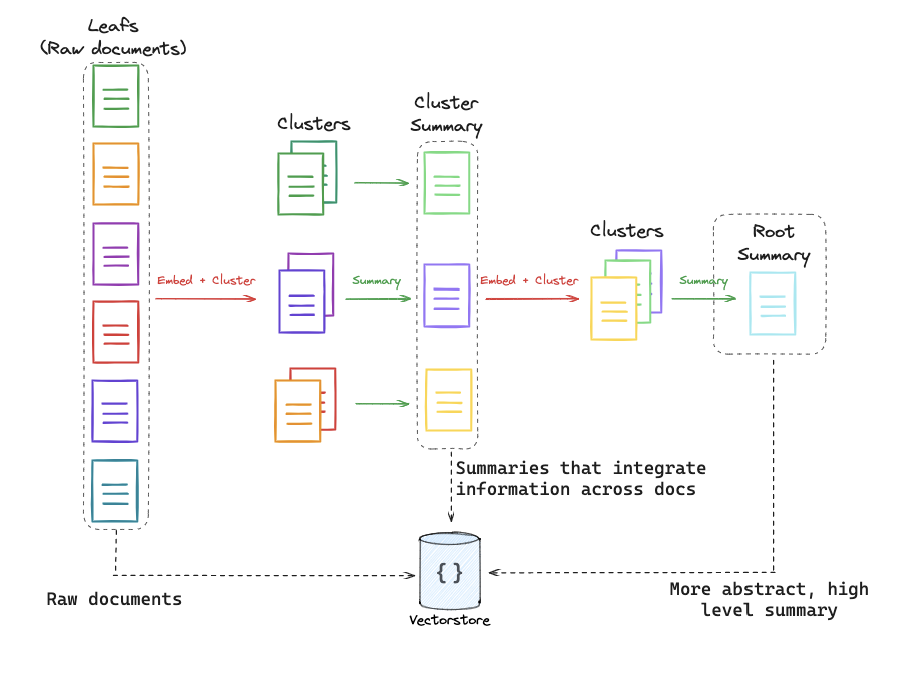

Deep dive video:

- https://www.youtube.com/watch?v=jbGchdTL7d0

Paper:

- https://arxiv.org/pdf/2401.18059.pdf

Full code:

- https://github.com/langchain-ai/langchain/blob/master/cookbook/RAPTOR.ipynb

## Part 14: ColBERT Indexing

RAGatouille makes it as simple to use ColBERT.

ColBERT generates a contextually influenced vector for each token in the passages.

ColBERT similarly generates vectors for each token in the query.

**RAGatouille example usage** : https://github.com/AnswerDotAI/RAGatouille

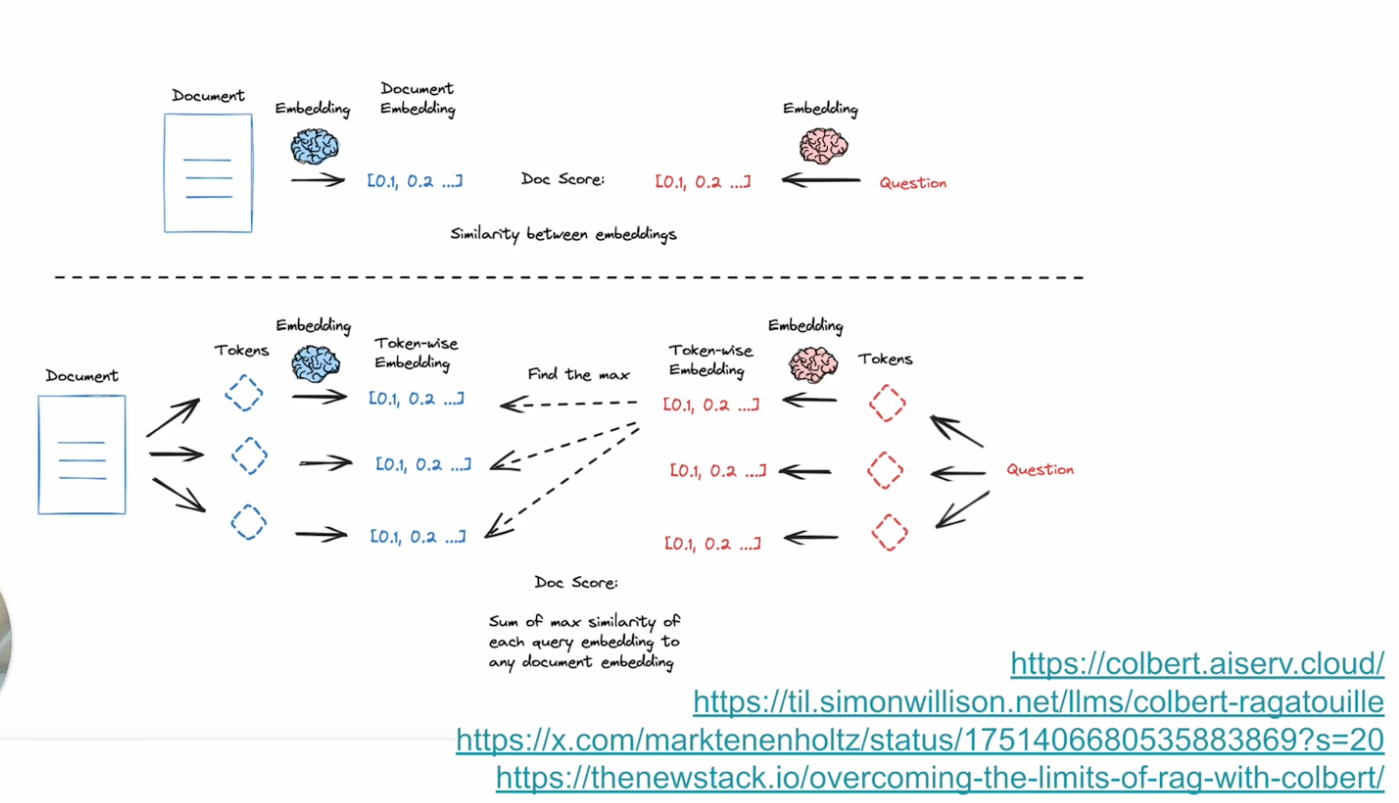

Then, the score of each document is the sum of the maximum similarity of each query embedding to any of the document embeddings:

See
- https://hackernoon.com/how-colbert-helps-developers-overcome-the-limits-of-rag
- https://python.langchain.com/docs/integrations/retrievers/ragatouille/
- https://til.simonwillison.net/llms/colbert-ragatouille


In [8]:
! uv pip install -U ragatouille


Using Python 3.10.8 environment at: /Users/I562107/Documents/workspace/open_source/practice-projects/llmFromGroundUp/.venv
Resolved 131 packages in 3.11s                                       
⠙ Preparing packages... (0/50)                                                  
⠙ Preparing packages... (0/50)-------------     0 B/15.85 KiB           
⠙ Preparing packages... (0/50)-------------     0 B/15.85 KiB           
filelock             ------------------------------     0 B/15.68 KiB
⠙ Preparing packages... (0/50)-------------     0 B/15.85 KiB           
filelock             ------------------------------     0 B/15.68 KiB
⠙ Preparing packages... (0/50)-------------     0 B/15.85 KiB           
filelock             ------------------------------     0 B/15.68 KiB
⠙ Preparing packages... (0/50)-------------     0 B/15.85 KiB           
striprtf             ------------------------------     0 B/6.75 KiB
filelock             ------------------------------     0 B/15.68 KiB
⠙ Preparing 

In [ ]:
🚨#### Expensive operation, run once #######

from ragatouille import RAGPretrainedModel
RAG = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

/var/folders/56/hr4t2kyn4zd1r_vn51tycxyh0000gn/T/ipykernel_49684/276443619.py:1: UserWarning: 
********************************************************************************
RAGatouille WARNING: Future Release Notice
--------------------------------------------
RAGatouille version 0.0.10 will be migrating to a PyLate backend 
instead of the current Stanford ColBERT backend.
PyLate is a fully mature, feature-equivalent backend, that greatly facilitates compatibility.
However, please pin version <0.0.10 if you require the Stanford ColBERT backend.
********************************************************************************
  from ragatouille import RAGPretrainedModel
/Users/I562107/Documents/workspace/open_source/practice-projects/llmFromGroundUp/.venv/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'validate_default' attribute with value True was provided to the `Field()` function, which has no effect in the context i

In [1]:
import requests

def get_wikipedia_page(title: str):
    """
    Retrieve the full text content of a Wikipedia page.

    :param title: str - Title of the Wikipedia page.
    :return: str - Full text content of the page as raw string.
    """
    # Wikipedia API endpoint
    URL = "https://en.wikipedia.org/w/api.php"

    # Parameters for the API request
    params = {
        "action": "query",
        "format": "json",
        "titles": title,
        "prop": "extracts",
        "explaintext": True,
    }

    # Custom User-Agent header to comply with Wikipedia's best practices
    headers = {"User-Agent": "RAGatouille_tutorial/0.0.1 (ben@clavie.eu)"}

    response = requests.get(URL, params=params, headers=headers)
    data = response.json()

    # Extracting page content
    page = next(iter(data["query"]["pages"].values()))
    return page["extract"] if "extract" in page else None

full_document = get_wikipedia_page("Hayao_Miyazaki")

In [2]:
RAG.index(
    collection=[full_document],
    index_name="Miyazaki-123",
    max_document_length=180,
    split_documents=True,
)

NameError: name 'RAG' is not defined

In [3]:
results = RAG.search(query="What animation studio did Miyazaki found?", k=3)
results

NameError: name 'RAG' is not defined

In [ ]:
retriever = RAG.as_langchain_retriever(k=3)
retriever.invoke("What animation studio did Miyazaki found?")

# Adaptive RAG

**langchain tutorial** : https://www.youtube.com/watch?v=04ighIjMcAI

 - Code-example https://github.com/langchain-ai/langgraph/blob/main/examples/rag/langgraph_adaptive_rag_cohere.ipynb